# Poster viewer distribution by SfN theme

by Scott Cole

This notebook describes the data collected on poster viewing at the 2016 Society for Neuroscience annual meeting. Specifically, we look at the distribution of viewers at each poster and how that varies with the neuroscience theme. This shows that the Development theme is substantially less popular than other themes, such as Cognition.

For more details, see the associated blog post at srcole.github.io.

# 0. Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tools.plt import scatt_corr, unpair_2cond, scatt_2cond

import seaborn as sns
sns.set_style('white')

import pandas as pd

# 1. Load data

In [2]:
df = pd.DataFrame.from_csv('./posterviewers_theme.csv')

In [3]:
key_S = 'Session'
key_P = 'Poster number'
key_N = 'Number of people'
key_T = 'Minutes since 1pm'

# 2. Distributions of viewers for all posters

In [4]:
# Count missing and withdrawn posters
N_posters = len(df)
print '# of total posters:', N_posters

N_withdrawn = sum(df['Number of people']=='W')
print '# of withdrawn posters:', N_withdrawn, ',', np.round(100*N_withdrawn/float(N_posters),1),'%'

N_missing = sum(df['Number of people']=='99')
print '# of missing posters:', N_missing, ',', np.round(100*N_missing/float(N_posters),1),'%'

N_empty = sum(df['Number of people']=='0')
print '# of no viewers:', N_empty, ',', np.round(100*N_empty/float(N_posters),1),'%'

# Remove missing and withdrawn posters
df = df[df[key_N]!='W']
df = df[df[key_N]!='99']

# Convert observations to ints
df[key_N] = df[key_N].astype(int)

# of total posters: 2579
# of withdrawn posters: 43 , 1.7 %
# of missing posters: 142 , 5.5 %
# of no viewers: 440 , 17.1 %


([<matplotlib.axis.XTick at 0xc1f6898>,
 <a list of 6 Text xticklabel objects>)

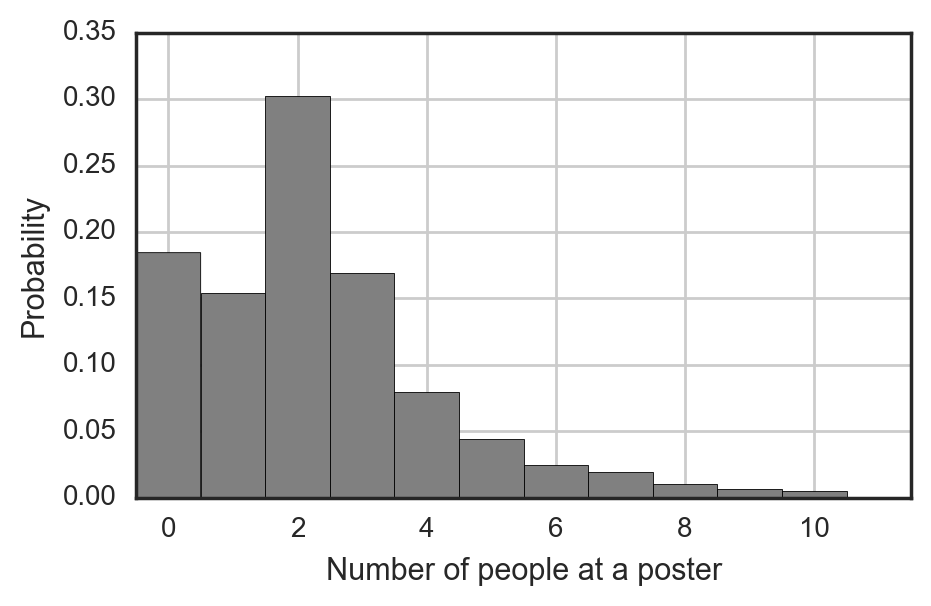

In [5]:
plt.figure(figsize=(5,3))
bins = range(12)
df.hist(key_N,bins=bins,ax=plt.gca(),normed=True,color='.5')
plt.xlabel('Number of people at a poster')
plt.ylabel('Probability')
plt.title('')
plt.xticks(np.arange(0.5,11.5,2),np.arange(0,11,2))

# 3. Distributions of viewers separated by theme

In [6]:
# Separate df into groups by Theme
dfs_grouped = {}
obj_grouped = df.groupby('Theme')
ks_Theme = obj_grouped.groups.keys()
for k in ks_Theme:
    dfs_grouped[k] = obj_grouped.get_group(k)
    
# Remove 'Techniques' because only 2 posters were counted. Rest have at least 156
dfs_grouped.pop('Techniques')
ks_Theme.remove('Techniques')

In [7]:
# Count of number of posters in each theme for each day
for k in ks_Theme:
    print k,':',len(dfs_grouped[k])

Development : 273
Neural excitability, synapses, and glia : 467
Cognition : 227
Motor systems : 333
Motivation and emotion : 150
Sensory systems : 333
Neurodegenerative disorders and injury : 353
Integrative physiology and behavior : 256


In [8]:
# Calculate probability distribution for each theme
N_themes = len(ks_Theme)
bins = np.arange(-.5,11,1)
N_bins = len(bins)-1
normviewerdist_bytheme = np.zeros((N_themes,N_bins))
for i in range(N_themes):
    normviewerdist_bytheme[i], bin_edges = np.histogram(dfs_grouped[ks_Theme[i]][key_N],bins=bins,density=True)

In [9]:
# Sort themes by average number of people

# Calculate weighted average
weightedavg_bytheme = np.zeros(N_themes)
for i in range(N_themes):
    weightedavg_bytheme[i] = np.average(range(11),weights=normviewerdist_bytheme[i])
    
# Get ranking of each theme
theme_ranks = sp.stats.rankdata(weightedavg_bytheme).astype(int) - 1
    
# Sort themes by weighted average
ks_Theme_sort = ['']*N_themes
weightedavg_sort = np.zeros(N_themes)
normviewerdist_sort = np.zeros((N_themes,N_bins))
for i, irank in enumerate(theme_ranks):
    ks_Theme_sort[irank] = ks_Theme[i]
    weightedavg_sort[irank] = weightedavg_bytheme[i]
    normviewerdist_sort[irank] = normviewerdist_bytheme[i]

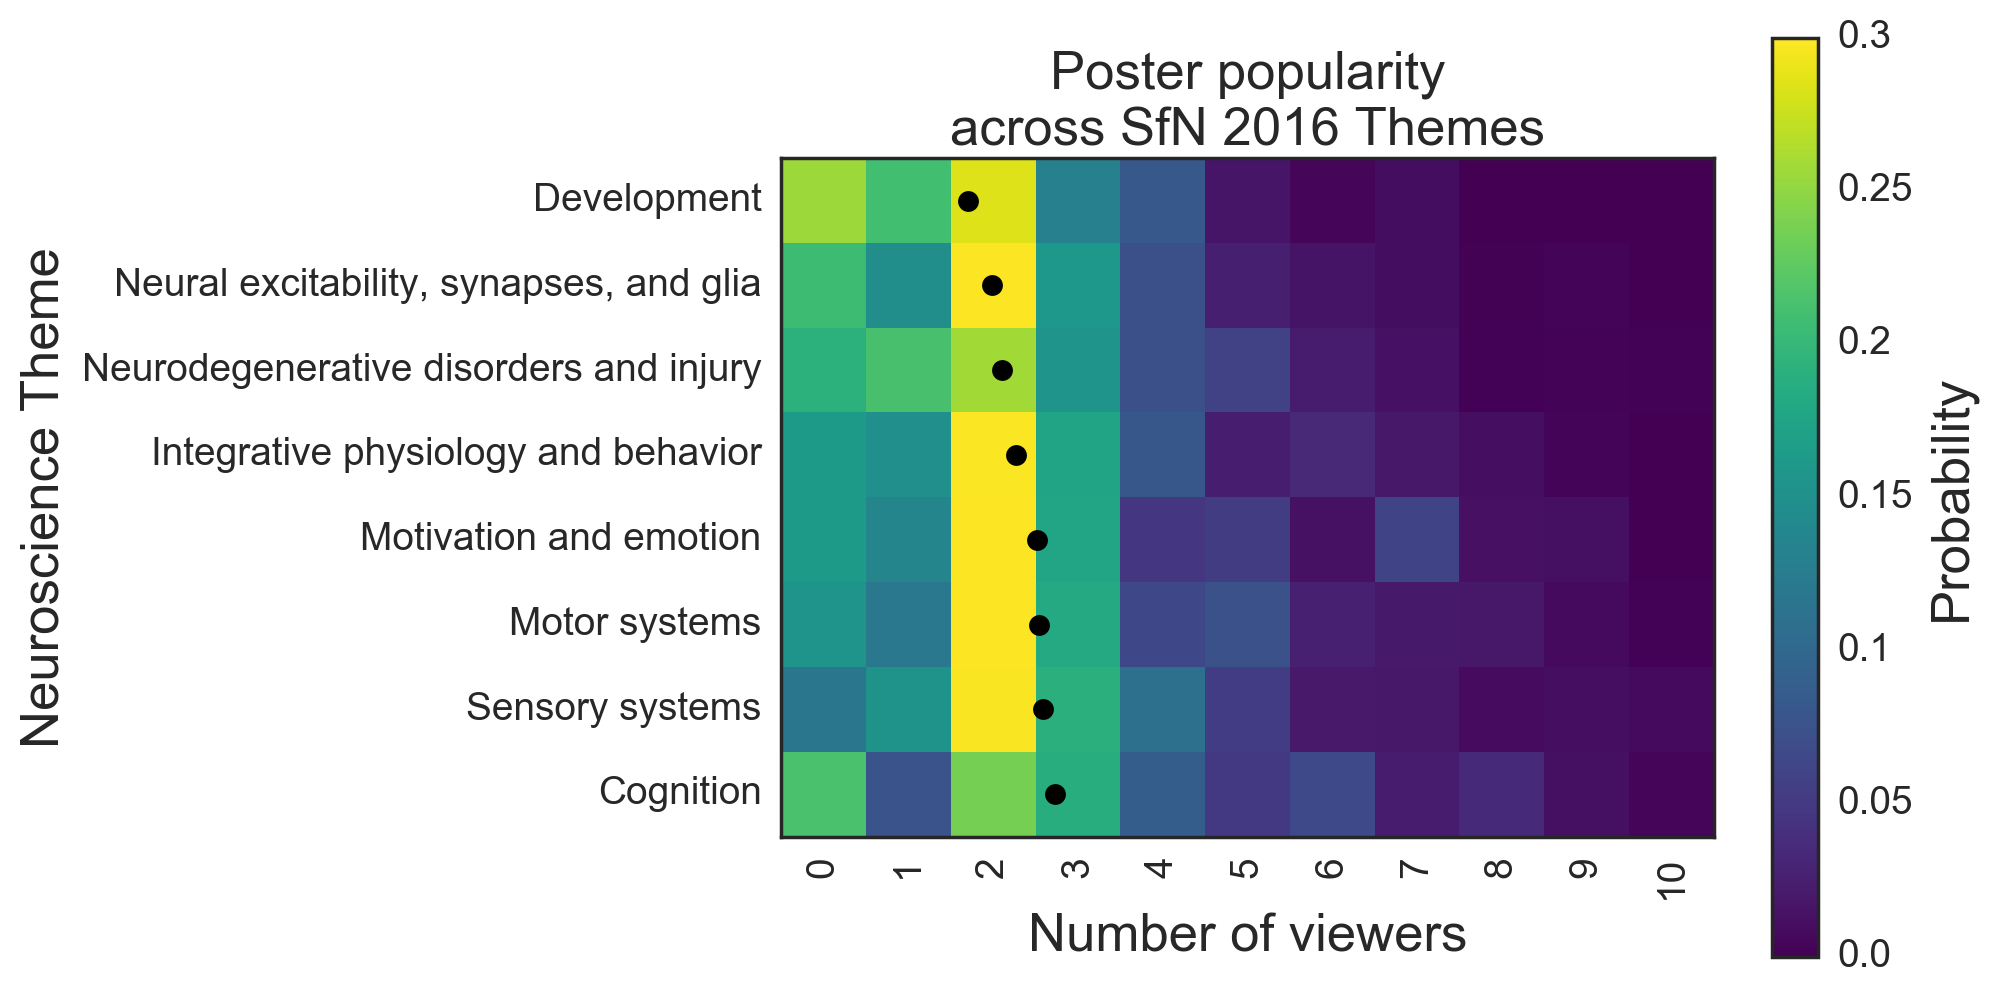

In [10]:
# Make a 2d colorplot
from tools.plt import color2d #from the 'srcole/tools' repo
from matplotlib import cm
color2d(normviewerdist_sort, cmap=cm.viridis,figsize=(10,6),
        clim=[0,.3], cticks = np.arange(0,.31,.05), color_label='Probability',
            plot_title='Poster popularity\nacross SfN 2016 Themes',
            plot_xlabel='Number of viewers', plot_ylabel='Neuroscience Theme',
            plot_xticks_locs=range(N_bins), plot_xticks_labels=range(N_bins),
            plot_yticks_locs=range(N_themes), plot_yticks_labels=ks_Theme_sort,
        interpolation='none', fontsize_minor=14, fontsize_major=19)

# On top, plot the mean
plt.plot(weightedavg_sort,range(8),'k.',ms=15)

# 4. Significantly more viewers at cognition and systems posters compared to development
Note that this significant difference holds true for each case across all sessions which had a sufficient number of posters for comparison (Sunday PM and Tuesday PM)

In [11]:
# Compare development and cognition across each session
k1 = 'Development'
k2 = 'Cognition'
sessions_devcog = df['Session'].unique()
print k1,' vs. ',k2
for s in sessions_devcog:
    print 'Session:', s
    df_t1 = dfs_grouped[k1]
    df_t2 = dfs_grouped[k2]
    N1 = df_t1[df_t1[key_S]==s][key_N]
    N2 = df_t2[df_t2[key_S]==s][key_N]
    print 'Number of posters in',k1,':',len(N1)
    print 'Number of posters in',k2,':',len(N2)
    if len(N1) > 5 and len(N2) > 5:
        print sp.stats.ttest_ind(N1, N2)
    else:
        print 'Not enough data for this session'

Development  vs.  Cognition
Session: Sunday PM
Number of posters in Development : 69
Number of posters in Cognition : 118
Ttest_indResult(statistic=-3.6307716009614928, pvalue=0.00036568643072504195)
Session: Monday PM
Number of posters in Development : 93
Number of posters in Cognition : 0
Not enough data for this session
Session: Tuesday PM
Number of posters in Development : 111
Number of posters in Cognition : 108
Ttest_indResult(statistic=-5.7735873507544104, pvalue=2.6629923917481779e-08)
Session: Wednesday PM
Number of posters in Development : 0
Number of posters in Cognition : 1
Not enough data for this session


In [12]:
# Compare development and sensory systems across each session
k1 = 'Development'
k2 = 'Sensory systems'
sessions_devcog = df['Session'].unique()
print k1,' vs. ',k2
for s in sessions_devcog:
    print 'Session:', s
    df_t1 = dfs_grouped[k1]
    df_t2 = dfs_grouped[k2]
    N1 = df_t1[df_t1[key_S]==s][key_N]
    N2 = df_t2[df_t2[key_S]==s][key_N]
    print 'Number of posters in',k1,':',len(N1)
    print 'Number of posters in',k2,':',len(N2)
    if len(N1) > 5 and len(N2) > 5:
        print sp.stats.ttest_ind(N1, N2)
    else:
        print 'Not enough data for this session'

Development  vs.  Sensory systems
Session: Sunday PM
Number of posters in Development : 69
Number of posters in Sensory systems : 154
Ttest_indResult(statistic=-6.2017041867187173, pvalue=2.7138148080015423e-09)
Session: Monday PM
Number of posters in Development : 93
Number of posters in Sensory systems : 0
Not enough data for this session
Session: Tuesday PM
Number of posters in Development : 111
Number of posters in Sensory systems : 52
Ttest_indResult(statistic=-3.2714074279844514, pvalue=0.0013092290303944882)
Session: Wednesday PM
Number of posters in Development : 0
Number of posters in Sensory systems : 127
Not enough data for this session


In [13]:
# Compare development and motor systems across each session
k1 = 'Development'
k2 = 'Motor systems'
sessions_devcog = df['Session'].unique()
print k1,' vs. ',k2
for s in sessions_devcog:
    print 'Session:', s
    df_t1 = dfs_grouped[k1]
    df_t2 = dfs_grouped[k2]
    N1 = df_t1[df_t1[key_S]==s][key_N]
    N2 = df_t2[df_t2[key_S]==s][key_N]
    print 'Number of posters in',k1,':',len(N1)
    print 'Number of posters in',k2,':',len(N2)
    if len(N1) > 5 and len(N2) > 5:
        print sp.stats.ttest_ind(N1, N2)
    else:
        print 'Not enough data for this session'

Development  vs.  Motor systems
Session: Sunday PM
Number of posters in Development : 69
Number of posters in Motor systems : 129
Ttest_indResult(statistic=-5.6024322095520827, pvalue=7.0878926223605652e-08)
Session: Monday PM
Number of posters in Development : 93
Number of posters in Motor systems : 1
Not enough data for this session
Session: Tuesday PM
Number of posters in Development : 111
Number of posters in Motor systems : 152
Ttest_indResult(statistic=-3.5385425575972445, pvalue=0.00047613306327649228)
Session: Wednesday PM
Number of posters in Development : 0
Number of posters in Motor systems : 51
Not enough data for this session
